<a href="https://colab.research.google.com/github/saritmaitra/roll_forward_validation/blob/main/Roll_Forward.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

In [2]:
# ticker = "CL=F"
# start_date = dt.datetime(2010,12,31)
# end_date = dt.datetime.today()
# class DataBase():
#   def __init__(self, ticker):
#     self.ticker = ticker
#     data = yf.download(ticker, start = start_date, end = end_date,
#                        freq = 'M')
#     self.df = pd.DataFrame(data)
#     pd.set_option("display.max_columns", None)
#     # self.df[self.df.index.dayofweek < 5]
    
#   def quote(self):
#     return self.df

# db = DataBase(ticker)
# df = db.quote()
# print(df.tail())

In [3]:
from pandas import DataFrame, concat
def get_data_model():
    ticker = "CL=F"
    start_date = dt.datetime(2010,1,1)
    end_date = dt.datetime.today()
    data = yf.download(ticker, start = start_date, end =end_date)
    df = DataFrame(data)
    pd.set_option("display.max_columns", None)   
    df = df.astype(float)
    return df
df = get_data_model()
print(df.head())


[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2010-01-04  79.629997  81.680000  79.629997  81.510002  81.510002  263542.0
2010-01-05  81.629997  82.000000  80.949997  81.769997  81.769997  258887.0
2010-01-06  81.430000  83.519997  80.849998  83.180000  83.180000  370059.0
2010-01-07  83.199997  83.360001  82.260002  82.660004  82.660004  246632.0
2010-01-08  82.650002  83.470001  81.800003  82.750000  82.750000  310377.0


In [4]:
mtly_return = df['Adj Close'].resample('M').mean().pct_change() 

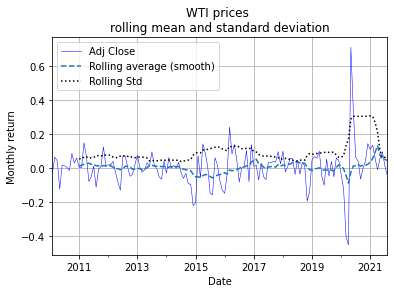

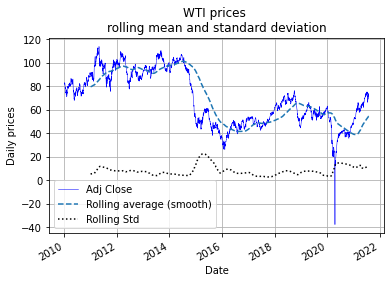

In [5]:
def rolling_statistics_ts(ts, title, ylabel, window_size=12):
  ts.plot(style='-', color = 'blue',lw=0.5)
  ts.rolling(window_size).mean().plot(style='--', label='Rolling average (smooth)')
  ts.rolling(window_size).std().plot(style=':', color='black', label='Rolling Std')
  plt.legend(loc='best')
  plt.ylabel(ylabel)
  plt.title(title); plt.grid(True)
  plt.show(block=False)
rolling_statistics_ts(mtly_return[1:],'WTI prices \nrolling mean and standard deviation','Monthly return')
rolling_statistics_ts(df['Adj Close'],'WTI prices \nrolling mean and standard deviation','Daily prices',252)

In [6]:
# mtly_return = (df['Adj Close']/ df['Adj Close'].shift(1)) -1
# mtly_return

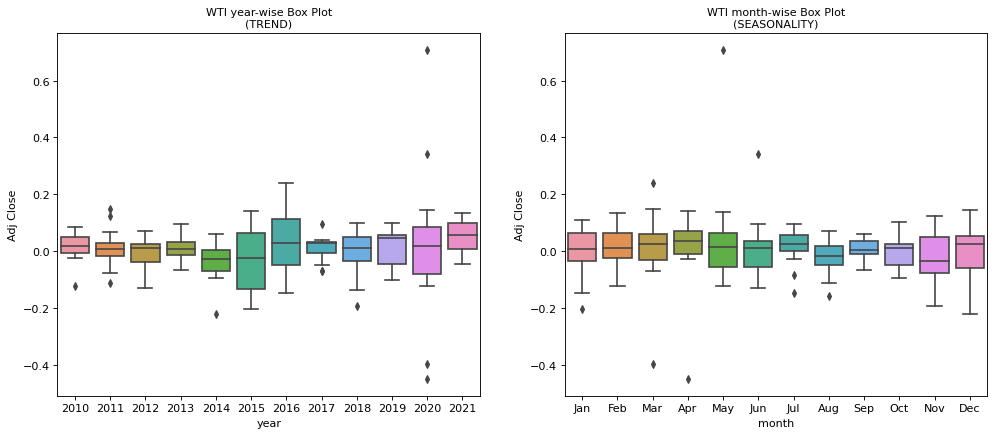

In [7]:
import seaborn as sns

start_date = dt.datetime(2010,1,1)
end_date = dt.datetime.today()
d = mtly_return.reset_index()

d['year'] = [i.year for i in d.Date]
d['month'] = [i.strftime('%b') for i in d.Date]
years = d['year'].unique()

fig, axes = plt.subplots(1, 2, figsize=(15,6), dpi= 80)
sns.boxplot(x='year', y='Adj Close', data=d, ax=axes[0])
sns.boxplot(x='month', y='Adj Close', data=d.loc[~d.year.isin([start_date, end_date]), :])

axes[0].set_title('WTI year-wise Box Plot\n(TREND)', fontsize=10); 
axes[1].set_title('WTI month-wise Box Plot\n(SEASONALITY)', fontsize=10)
plt.show()

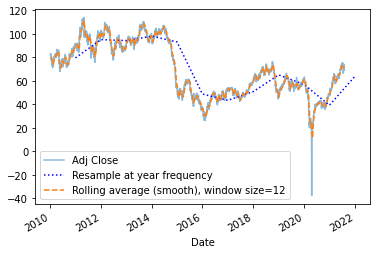

In [8]:
d = df['Adj Close']
resamp_yr = d.resample('A').mean()
roll_yr = d.rolling(12).mean()
ax = d.plot(alpha=0.5, style='-') # store axis (ax) for latter plots
resamp_yr.plot(style=':', color ='b', label='Resample at year frequency', ax=ax)
roll_yr.plot(style='--', label='Rolling average (smooth), window size=12', ax=ax)
ax.legend()

## First-order dierencing: Seasonal Patterns

Text(0.5, 0, 'Year')

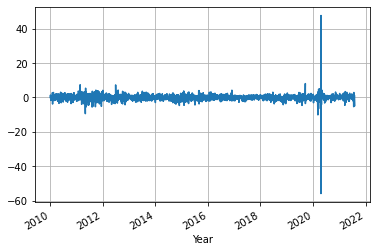

In [9]:
import numpy as np

# diff = original - shiftted data
# (exclude first term for some implementation details)
# assert np.all((d.diff() == d - d.shift())[1:])
d.diff().plot()
plt.grid(True)
plt.xlabel('Year')

## Autocorrelation
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months.

Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant t1. . . t2 with series at instant t1-5. . . t2-5 (t1-5 and t2 being end points).

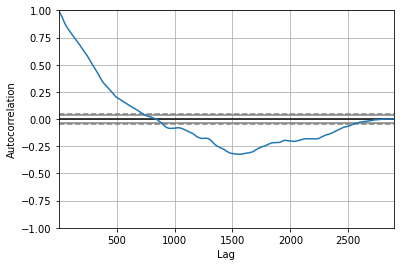

In [10]:
from pandas.plotting import autocorrelation_plot
# autocorrelation plot
x = df["Adj Close"].astype(float)
autocorrelation_plot(x)
plt.show()

## Compute Autocorrelation Function (ACF)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Autocorrelation Function')

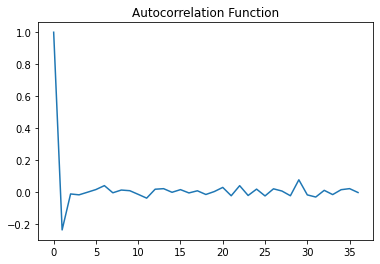

In [11]:
from statsmodels.tsa.stattools import acf
x_diff = x.diff().dropna() # first item is NA
lag_acf = acf(x_diff, nlags=36)
plt.plot(lag_acf)
plt.title('Autocorrelation Function')

In [12]:
 from statsmodels.tsa.stattools import adfuller

def adf_test(series):
  print('Results of Dickey-Fuller Test:')
  adf_test = adfuller(series[1:], autolag='AIC')
  adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'pvalue',
                                              '#Lags Used', 'Number of Observations Used'])
  print (adf_output)

print('Stationarity_Daily data:')
print(adf_test(df['Adj Close'])); print()
# print('Stationarity_Daily return:')
# print(adf_test(x_diff)); print()
print('Stationarity_differenced series:')
print(adf_test(x_diff))

Stationarity_Daily data:
Results of Dickey-Fuller Test:
Test Statistic                   -1.676545
pvalue                            0.443236
#Lags Used                       11.000000
Number of Observations Used    2879.000000
dtype: float64
None

Stationarity_differenced series:
Results of Dickey-Fuller Test:
Test Statistic                -1.658307e+01
pvalue                         1.826844e-29
#Lags Used                     1.000000e+01
Number of Observations Used    2.879000e+03
dtype: float64
None


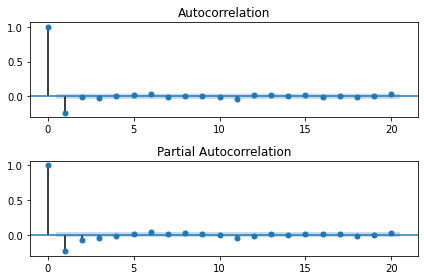

In [13]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

lags = 20
sig_level = 0.05
fig, ax = plt.subplots(2, 1)
plot_acf(x_diff, ax=ax[0], lags=lags, alpha=sig_level)
plot_pacf(x_diff, ax=ax[1], lags=lags, alpha=sig_level)
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


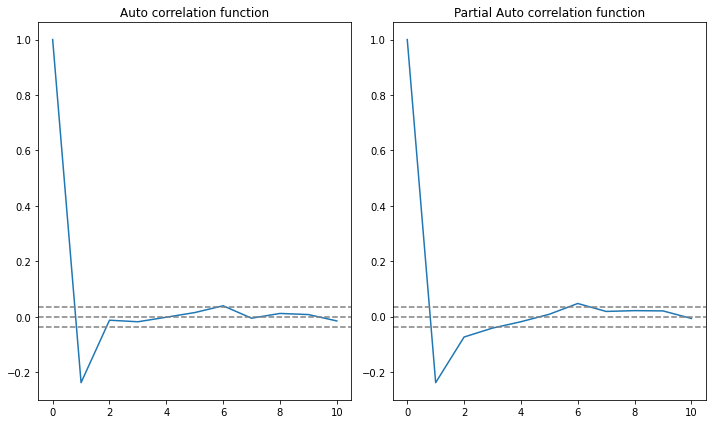

In [14]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np

x = df["Adj Close"].astype(float)
x_diff = x.diff().dropna() # first item is NA

plt.figure(figsize = (10,6))

lag_acf = acf(x_diff, nlags=10)
lag_pacf = pacf(x_diff, nlags=10, method = 'ols')

# plot acf
plt.subplot(121); plt.plot(lag_acf);
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.title('Auto correlation function')

# plot pacf
plt.subplot(122); plt.plot(lag_pacf);
plt.axhline(y=0, linestyle='--', color = 'gray')
plt.axhline(y=-1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.axhline(y=1.96/np.sqrt(len(x_diff)), linestyle='--', color = 'gray')
plt.title('Partial Auto correlation function'); plt.tight_layout();

In this plot, the two dotted lines on either sides of 0 are the confidence interevals. These can be used to determine the p and q values as:
- p: The lag value where the PACF chart crosses the upper confidence interval for the first time, in this case p=1.
- q: The lag value where the ACF chart crosses the upper confidence interval for the first time, in this case q=1.



In [ ]:
pip install hurst

In [23]:
import hurst 
from hurst import compute_Hc, random_walk
H, c, data = compute_Hc(
    x, 
    kind='random_walk', 
    simplified=True
    )
print(H, c)

0.5238523583400265 1.274844204374221


- The value of H < 0.5 indicates anti-persistent behavior, and 
- H> 0.5 indicates persistent behavior or a serial trend. 
- H = 0.5 shows a random walk / Brownian motion. 
- The value of H < 0.5, confirming that our series is stationary area.

In [17]:
# train, test = mtly_return[:100], mtly_return[100:]

In [18]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

# # x.index = pd.DatetimeIndex(x.index).to_period('M')
# model = ARIMA(x, order=(1, 1, 1))
# model_fit = model.fit()
# x.plot()
# model_fit.fittedvalues.plot(color='gray')
# plt.title('RSS: %.4f'% sum((model_fit.fittedvalues - x)**2))
# plt.grid(True); plt.show()

In time series modelling, the predictions over time become less and less accurate and hence it is a more realistic approach to re-train the model with actual data as it gets available for further predictions. Since training of statistical models are not time consuming, walk-forward validation is the most preferred solution to get most accurate results.

Let us apply one step walk forward validation on our data and compare it with the results we got earlier.

In [24]:
import warnings
from math import sqrt

# x.index = pd.DatetimeIndex(x.index).to_period('D')
# split into train and test sets
size = int(len(x) * 0.90)
train, test = x[0:size], x[size:len(x)]
# print(len(train)); len(test)) # 2377, 265

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,1)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction

In [25]:
# test_.index = pd.to_datetime(test_.index)
print(test_)

            Adj Close  predictions_wf
Date                                 
2020-06-05  39.549999       37.264898
2020-06-08  38.189999       38.918894
2020-06-09  38.939999       38.324794
2020-06-10  39.599998       38.770555
2020-06-11  36.340000       39.353271
...               ...             ...
2021-07-27  71.650002       71.858767
2021-07-28  72.389999       71.696741
2021-07-29  73.620003       72.211229
2021-07-30  73.949997       73.238433
2021-08-03  69.250000       73.732955

[290 rows x 2 columns]


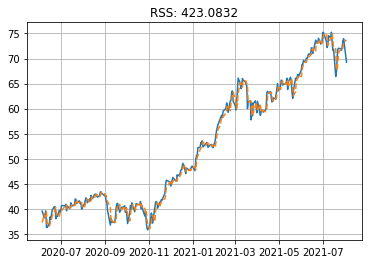

In [26]:
plt.plot(test_['Adj Close'])
plt.plot(test_.predictions_wf, '--')
plt.title('RSS: %.4f'% sum((test_.predictions_wf - test_['Adj Close'])**2))
plt.grid(True);plt.show()

In [27]:
size = int(len(x) * 0.90)
n_train = size
n_records = len(x)
for i in range(n_train, n_records):
  train, test = x[0:i], x[i:i+1]
  # print('train=%d, test=%d' % (len(train), len(test)))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

prediction = []
data = train.values
for t in test.values:
   model = ARIMA(data, order=(1,1,1)).fit(disp=0)
   y = model.forecast(steps=len(test))[0]
   prediction.append(y[0])
   data = np.append(data, t)

test_ = pd.DataFrame(test)
test_['predictions_wf'] = prediction
print(test_)

            Adj Close  predictions_wf
Date                                 
2021-08-03      69.25       73.732955


In [28]:
from sklearn.metrics import mean_squared_error
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARIMA with Walk-Forward Validation: ', error)

Test RMSE for ARIMA with Walk-Forward Validation:  4.482955053391365


We can see that our model performs significantly better now. In fact, the trend is followed so closely that on the plot predictions are overlapping with the actual values.

In [29]:
import warnings
from math import sqrt

# # split into train and test sets
# size = int(len(x) * 0.67)
# train, test = x[0:size], x[size:len(x)]
# history = [i for i in train]
# predictions = list()

# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")

# # walk-forward validation
# for t in range(len(test)):
#   model = ARIMA(history, order=(1,1,1))
#   model_fit = model.fit(disp=0)
#   y = model_fit.forecast(steps=len(test))[0]
#   yhat = output[0]
#   predictions.append(yhat)
#   obs = test[t]
#   history.append(obs)
#   print('predicted=%f, expected=%f' % (yhat, obs))

# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# # plot forecasts against actual outcomes
# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

In [30]:
# from pandas import DataFrame, concat
# from pandas.tseries.holiday import USFederalHolidayCalendar
# from pandas.tseries.offsets import CustomBusinessDay
# us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# forecast = int(15)
# pred, std, ci = (model_fit.forecast(forecast))

# pred = DataFrame(pred)
# d = DataFrame(df['Adj Close'].tail(len(pred))); d.reset_index(inplace = True)
# d = d.append(DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
#                                              periods = (len(d)+1), freq = 'm', 
#                                               closed = 'right')}))
# d = d.tail(forecast); d.set_index('Date', inplace = True)
# pred.index = d.index
# pred.rename(columns = {0: 'Forecast'}, inplace=True)

# # 95% prediction interval
# ci = DataFrame(ci)
# ci.rename(columns = {0: 'lower95', 1:'upper95'}, inplace=True)
# ci.index = pred.index

# ARIMA = concat([pred, ci], axis=1)
# ARIMA

In [31]:
from math import sqrt
from sklearn.metrics import mean_squared_error
error = sqrt(mean_squared_error(test.values, prediction))
print ('Test RMSE for ARMA with Walk-Forward Validation: ', error)

Test RMSE for ARMA with Walk-Forward Validation:  4.482955053391365


If we model the response variable as future pricecurrent price, then we are trying to predict the direction of the future price with regard to the current price (does it go up, does it go down, or does it remain the same), as well as the magnitude of the price change.

In [32]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [33]:
# from pandas import DataFrame, concat
# def get_data_model():
#     ticker = "CL=F"
#     start_date = dt.datetime(2010,12,31)
#     end_date = dt.datetime(2020,12,31)
#     data = yf.download(ticker, start = start_date, end =end_date)
#     df = pd.DataFrame(data)
#     pd.set_option("display.max_columns", None)   
#     df = df.astype(float)
#     return df

In [34]:
# from statsmodels.tsa.arima_model import ARIMA
# from pandas import DataFrame, concat

# def get_data_model():
#     ticker = "CL=F"
#     start_date = dt.datetime(2010,12,31)
#     end_date = dt.datetime(2020,12,31)
#     data = yf.download(ticker, start = start_date, end =end_date)
#     df = pd.DataFrame(data)
#     pd.set_option("display.max_columns", None)   
#     df = df.astype(float)
#     return df

# def run_model(df):
#   # parameters
#   fcast_out = int(15); mlags = int(10); order = (1,0,1)

#   model = ARIMA(mtly_return, order=(1, 0, 1))
#   model_fit = model.fit()

#   forecast = int(15)
#   pred, std, ci = (model_fit.forecast(forecast))

#   pred = DataFrame(pred)
#   d = DataFrame(df['Adj Close'].tail(len(pred))); d.reset_index(inplace = True)
#   d = d.append(DataFrame({'Date': pd.date_range(start = d.Date.iloc[-1], 
#                                                 periods = (len(d)+1), freq = us_bd, 
#                                                 closed = 'right')}))
#   d = d.tail(forecast); d.set_index('Date', inplace = True)
#   pred.index = d.index
#   pred.rename(columns = {0: 'Forecast'}, inplace=True)

#   # 95% prediction interval
#   ci = DataFrame(ci)
#   ci.rename(columns = {0: 'lower95', 1:'upper95'}, inplace=True)
#   ci.index = pred.index

#   forecast = concat([pred, ci], axis=1)
#   return forecast

In [35]:
# run_model(df)